In [515]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from scipy.ndimage.filters import gaussian_filter
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
%matplotlib inline

In [516]:
spark = SparkSession.builder\
    .appName("weather")\
    .getOrCreate()

In [517]:
fp = spark.read.csv('/Users/vvviren/Desktop/Film_Permits.csv',header='true')

cols = [
 'EventType',
 'EndDateTime',
 'EnteredOn',
 'EventAgency',
 'ParkingHeld',
 'Borough',
 'CommunityBoard(s)',
 'PolicePrecinct(s)',
 'Category',
 'SubCategoryName',
 'Country']
fp=fp.drop(*cols)

In [518]:
import pyspark.sql.functions as f

fp_day = fp.withColumn("date", f.to_date(f.to_timestamp("StartDateTime", "MM/dd/yyyy HH:mm:ss "))).drop("StartDateTime")

In [519]:
fp_day=fp_day.filter(f.year("date") == "2013")
fp_day=fp_day.withColumn("day", f.dayofyear("date")).drop("date")
fp_day.show()

+-------+-------------------+---+
|EventID|         ZipCode(s)|day|
+-------+-------------------+---+
| 128794|       10001, 10121|320|
| 104342|              10036|172|
|  82397|              11219|  7|
| 103691|              10010|144|
| 124219|11205, 11222, 11238|276|
|  89512|       11201, 11217| 67|
| 134744|              11224|353|
| 130915|              10002|325|
| 107528|       10003, 10009|168|
|  94339|              11363|104|
| 113303|10003, 10013, 10280|200|
| 132252|       10024, 10025|339|
| 124240|       11101, 11109|275|
| 131812|              10019|341|
|  95632|              10019|124|
|  96424|              10024|111|
|  98105|              10036|121|
|  83475|              11205| 16|
|  85205|10007, 10013, 10038| 35|
| 126892|              10019|301|
+-------+-------------------+---+
only showing top 20 rows



In [520]:
fp_d = fp_day.groupby("day").count().sort("day")
fp_d.show(365)

+---+-----+
|day|count|
+---+-----+
|  2|    4|
|  3|   12|
|  4|   11|
|  5|    2|
|  6|    6|
|  7|   14|
|  8|   18|
|  9|   23|
| 10|   23|
| 11|   19|
| 12|    5|
| 13|    2|
| 14|   16|
| 15|   20|
| 16|   23|
| 17|   26|
| 18|   24|
| 19|    6|
| 20|    4|
| 21|   17|
| 22|   19|
| 23|   19|
| 24|   22|
| 25|   20|
| 26|    6|
| 27|    3|
| 28|   19|
| 29|   17|
| 30|   20|
| 31|   27|
| 32|   25|
| 33|   11|
| 34|    3|
| 35|   20|
| 36|   14|
| 37|   16|
| 38|   21|
| 39|   21|
| 40|    1|
| 41|    4|
| 42|   18|
| 43|   16|
| 44|   22|
| 45|   20|
| 46|   26|
| 47|    9|
| 48|    4|
| 49|    7|
| 50|   15|
| 51|   19|
| 52|   20|
| 53|   21|
| 54|   10|
| 55|    8|
| 56|   19|
| 57|   22|
| 58|   22|
| 59|   25|
| 60|   23|
| 61|   10|
| 62|    8|
| 63|   16|
| 64|   17|
| 65|   20|
| 66|   20|
| 67|   20|
| 68|   10|
| 69|    7|
| 70|   18|
| 71|   16|
| 72|   22|
| 73|   25|
| 74|   21|
| 75|   11|
| 76|    7|
| 77|   14|
| 78|   17|
| 79|   23|
| 80|   31|
| 81|   30|
| 82

In [521]:
from pyspark.sql.types import IntegerType

# notice the variable name (more below)
mylist = range(1,366)

# notice the parens after the type name
ds = spark.createDataFrame(mylist, IntegerType())

In [522]:
days = ds.join(fp_d, fp_d["day"] == ds["value"], how="left").drop("day").withColumn("cnt", f.col("count")).drop("count")
days = days.withColumn("dayOfYear", f.col("value")).drop("value")
days = days.na.fill(0)
days.show()
lst=[]
n=5
while n<366:
    lst.append(n)
    lst.append(n+1)
    n+=7
weekdays = days.filter(days.dayOfYear.isin(*lst)==False )

+---+---------+
|cnt|dayOfYear|
+---+---------+
|  0|        1|
|  4|        2|
| 12|        3|
| 11|        4|
|  2|        5|
|  6|        6|
| 14|        7|
| 18|        8|
| 23|        9|
| 23|       10|
| 19|       11|
|  5|       12|
|  2|       13|
| 16|       14|
| 20|       15|
| 23|       16|
| 26|       17|
| 24|       18|
|  6|       19|
|  4|       20|
+---+---------+
only showing top 20 rows



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Second argument 'y1' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  import sys


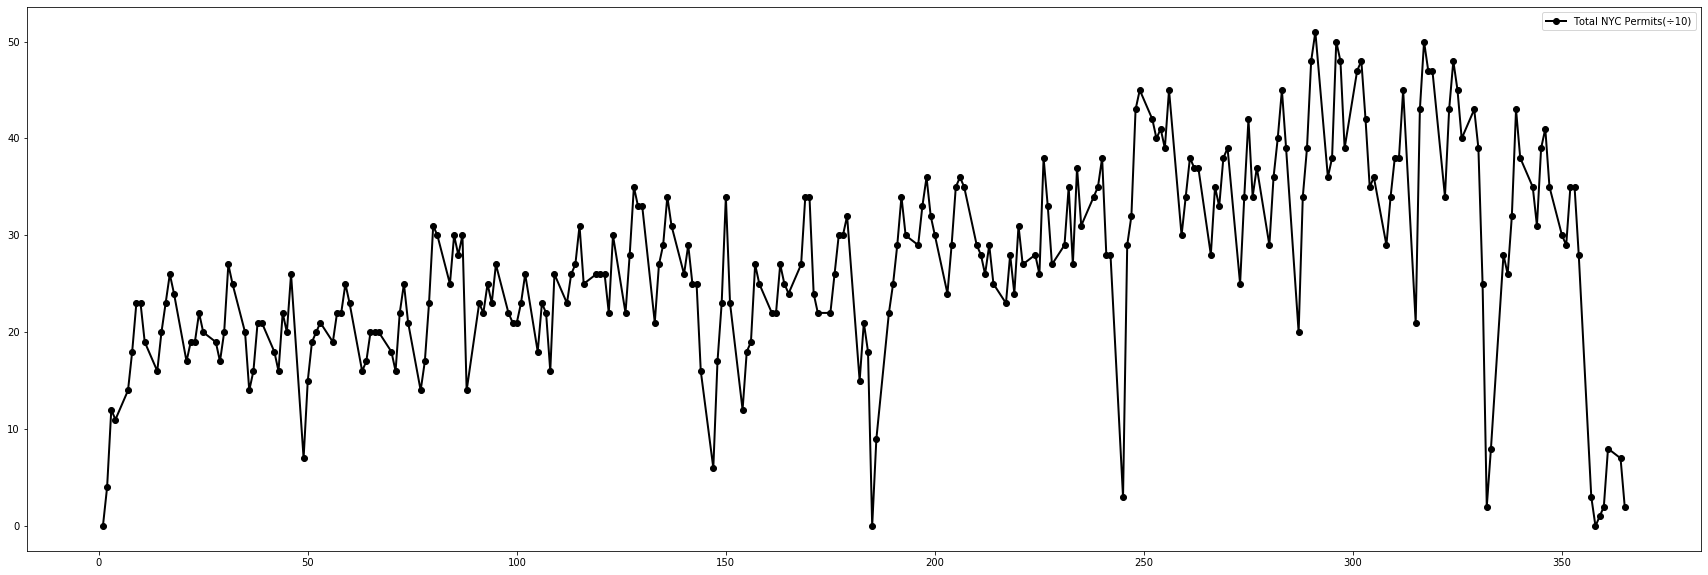

In [523]:
fp_d_pd = weekdays.toPandas()
df1=pd.DataFrame({'x': fp_d_pd["dayOfYear"]
                 ,'y1': fp_d_pd["cnt"]
                })

plt.figure(figsize=(30,10))
plt.plot( 'x', 'y1', data=df1, marker='o', color='black', linewidth=2, label="Total NYC Permits(÷10)")
plt.legend()

In [524]:
weekdays = weekdays.withColumn("cnt", f.expr("CAST(cnt AS INTEGER)"))

sd = weekdays.select(f.stddev(f.col("cnt")).alias("stddev")).collect()[0]["stddev"]
mean = weekdays.select(f.mean(f.col("cnt")).alias("mean")).collect()[0]["mean"]

print (mean)
print (sd)
low = weekdays.filter(days["cnt"] > 2*sd+mean)
high = weekdays.filter(days["cnt"] < -2*sd+mean)


low.show()
high.show()

27.103448275862068
10.34672131207825
+---+---------+
|cnt|dayOfYear|
+---+---------+
| 48|      290|
| 51|      291|
| 50|      296|
| 48|      297|
| 48|      302|
| 50|      317|
| 48|      324|
+---+---------+

+---+---------+
|cnt|dayOfYear|
+---+---------+
|  0|        1|
|  4|        2|
|  6|      147|
|  0|      185|
|  3|      245|
|  2|      332|
|  3|      357|
|  0|      358|
|  1|      359|
|  2|      360|
|  2|      365|
+---+---------+



In [525]:
weather = spark.read.csv('/Users/vvviren/MyDev/bd apps/2013.csv',header='true')
cols=['STN---',
 'WBAN ',
 '  4',
 '   DEWP',
 '  6',
 '  SLP  ',
 '  8',
 '  STP  ',
 '  10',
 ' VISIB',
 '  12',
 '  WDSP',
 '  14',
 ' MXSPD',
 '  GUST',
 '   MAX  ',
 '  MIN  ',
 'PRCP  ',
 'SNDP ',
 ' FRSHTT',
 '_c22']
weather=weather.drop(*cols)

In [526]:
weather = weather.withColumn("day", f.dayofyear(f.to_date(f.trim(f.col(' YEARMODA')), "yyyyMMdd"))).drop(' YEARMODA')

weather = weather.withColumn("temp", f.trim(f.col('   TEMP'))).drop('   TEMP')

weather = weather.withColumn("temp", f.col("temp").cast("float"))

In [527]:
weatherday = days.join(weather, weather["day"] == days["dayOfYear"], how="left").drop("dayOfYear")
weatherday.show()

+---+---+----+
|cnt|day|temp|
+---+---+----+
|  0|  1|37.8|
|  4|  2|27.1|
| 12|  3|28.4|
| 11|  4|33.4|
|  2|  5|36.1|
|  6|  6|38.3|
| 14|  7|40.9|
| 18|  8|40.7|
| 23|  9|43.8|
| 23| 10|44.3|
| 19| 11|40.5|
|  5| 12|44.6|
|  2| 13|45.3|
| 16| 14|52.5|
| 20| 15|37.9|
| 23| 16|34.2|
| 26| 17|39.2|
| 24| 18|30.2|
|  6| 19|37.3|
|  4| 20|45.3|
+---+---+----+
only showing top 20 rows



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Second argument 'y1' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Second argument 'y2' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  # Remove the CWD from sys.path while we load stuff.


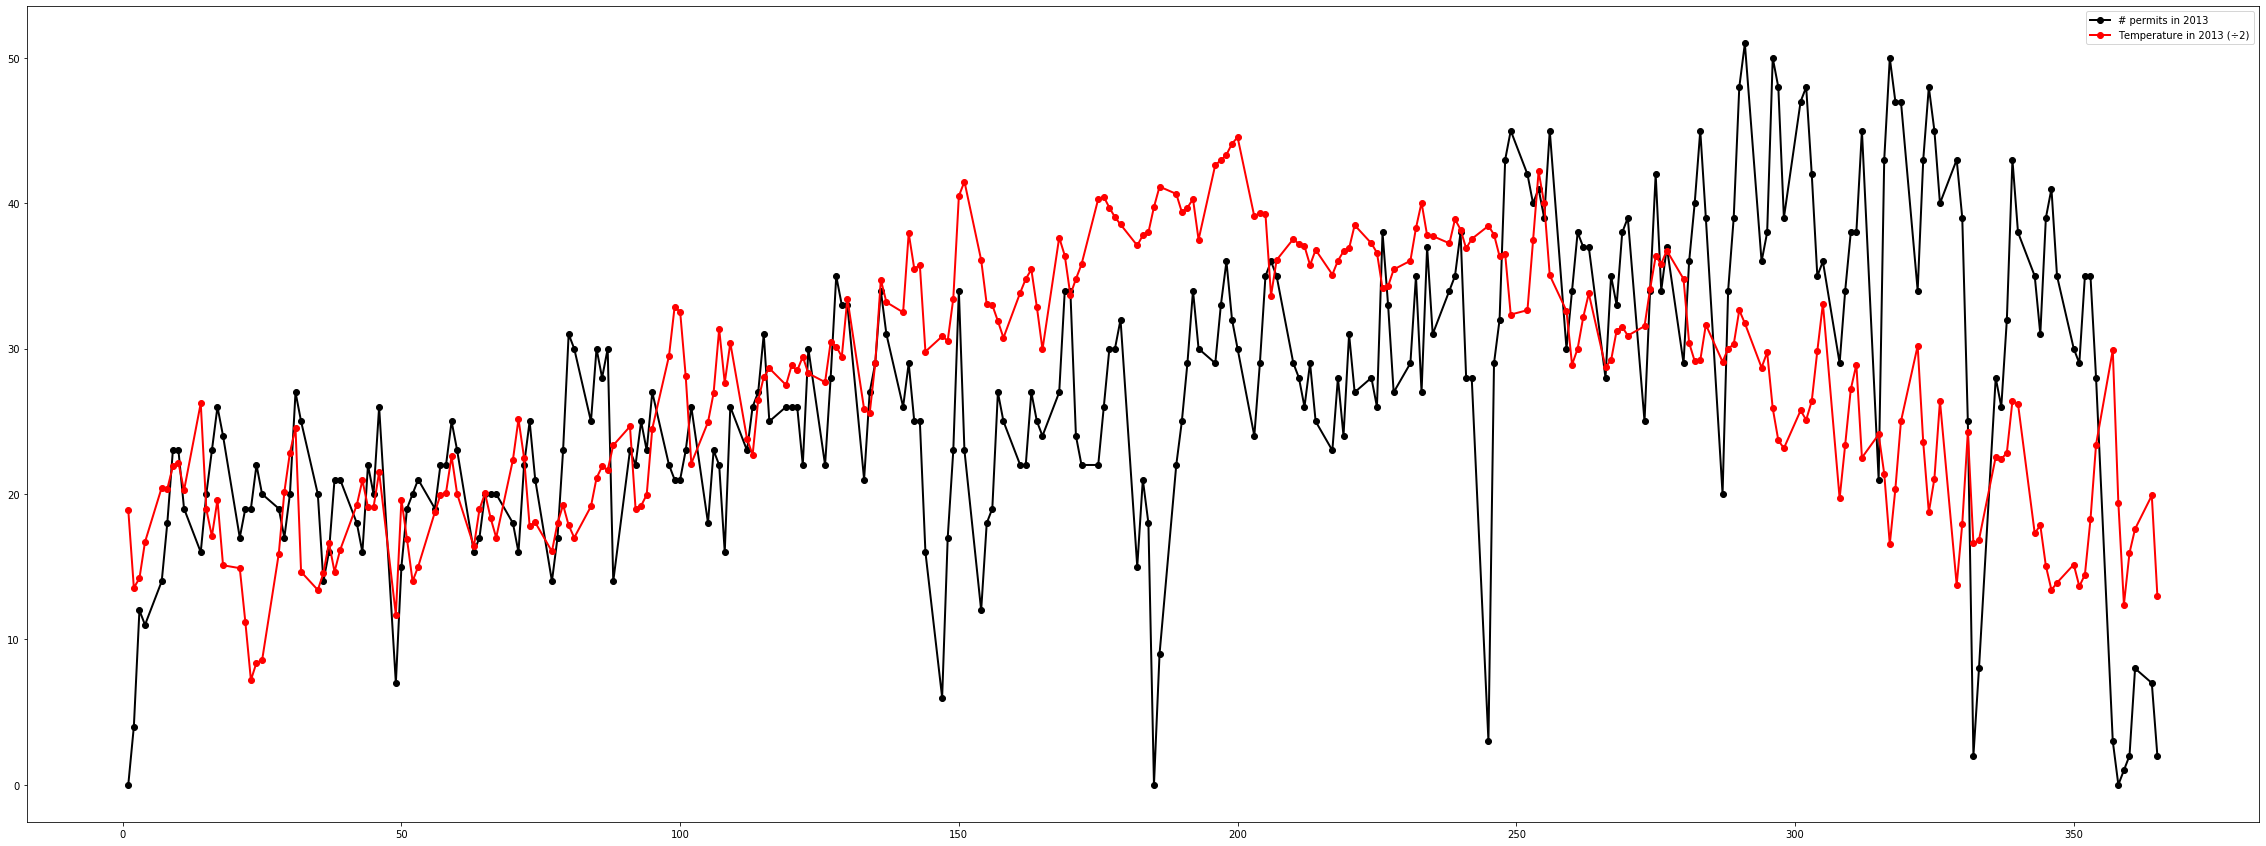

In [528]:
weather_pd = weatherday.toPandas()
weekdayweather_pd = weather_pd[~weather_pd['day'].isin(lst)]
df1=pd.DataFrame({'x': weekdayweather_pd["day"]
                 ,'y2': weekdayweather_pd["temp"]/2
                , 'y1': weekdayweather_pd["cnt"]
                })

fig = plt.figure(figsize=(40,15))
plt.plot( 'x', 'y1', data=df1, marker='o', color='black', linewidth=2, label="# permits in 2013")
plt.plot( 'x', 'y2', data=df1, marker='o', color='red', linewidth=2, label="Temperature in 2013 (÷2)")

plt.legend()
fig.savefig('/Users/vvviren/Desktop/WeatherCorrelation2013.png')


In [529]:
weatherday.stat.corr('cnt', 'temp')

0.19878961858168726